In [1]:
import numpy as np
import scipy.stats as sts
import pandas as pd
import pystan
import matplotlib.pyplot as plt
import os

In [2]:
os.getcwd() #Delete this cell if needed - I only use it to change the directory on my computer
os.chdir('D:\\Downloads-D')
os.getcwd()

'D:\\Downloads-D'

In [3]:
#importing and viewing the dataset
dta = pd.read_csv("CS146 LBA data.csv")
dta.head()

,Timestamp,Email Address,Your name,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Rent per m2,Product 1 quantity (kg),...,Product 2 quantity (count),Product 2 price.8,Product 3 quantity (count),Product 3 price.8,Product 1 quantity (kg).7,Product 1 price.9,Product 2 quantity (kg).7,Product 2 price.9,Product 3 quantity (kg).7,Product 3 price.9
0,10/20/2020 23:22,tiagoflora@minerva.kgi.edu,Tiago Flora,Germany,EUR,"EDEKA, Grunerstraße 20",Mid-range,EUR900,19.565217,1.0,...,6.0,1.75,4.0,1.99,0.312,3.97,0.600,3.87,0.400,2.90
1,10/20/2020 23:32,tiagoflora@minerva.kgi.edu,Tiago Flora,Germany,EUR,"EDEKA Andreasstraße 59, 10243 Berlin",Mid-range,EUR850,18.478261,1.0,...,6.0,2.73,10.0,1.63,0.394,5.02,0.430,7.17,0.311,9.12
2,10/23/2020 18:39,katja.dellalibera@minerva.kgi.edu,Katja Della Libera,Germany,EUR,"EDEKA BAUR, Gottlieber Str. 34, 78462 Konstanz",Mid-range,1000,21.739130,1.0,...,10.0,3.23,10.0,1.25,0.600,3.88,0.400,2.91,NaN,NaN
3,10/23/2020 18:40,katja.dellalibera@minerva.kgi.edu,Katja Della Libera,Germany,EUR,"Alnatura Super Natur Markt, Münzgasse 4A, 7846...",Luxury (expensive),1000,21.739130,1.0,...,10.0,1.99,1.0,0.45,1.000,32.90,NaN,NaN,NaN,NaN
4,10/28/2020 13:10,cameronwatts@minerva.kgi.edu,Cameron Watts,Germany,EUR,"EDEKA, Annenstraße 4A",Budget (cheap),895,19.456522,1.0,...,6.0,2.44,10.0,2.34,0.600,3.87,0.392,4.99,0.333,3.26


In [4]:
#Dropping irrelevant columns: timestamp, email address, name
dta = dta.drop(['Timestamp', 'Email Address', 'Your name'], axis=1)
#Getting the unique list of grocery stores

In [5]:
'''
First, we make sure the grocery stores are unique. In the data, one store has overlapping data points and has different 
names, which is Trader Joe's on 4th Street of SF.
'''
for i in range(len(dta['Grocery store name and street address (or URL if shopping online)'])):
    if dta['Grocery store name and street address (or URL if shopping online)'].loc[i] == "Trader Joe's - 10 4th Street":
        dta['Grocery store name and street address (or URL if shopping online)'].loc[i] = "Trader Joe's, 10 4th St, San Francisco, CA 94103"


D:\Downloads-D\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
'''
Now we move on to normalizing the prices.
'''
#First, we find the price per unit. Starts from column 5, end at the second to last column (last one is store name)
for column in range(6, len(dta.columns)-1, 2):
    #Divide the price column with the quantity column to get price per unit
    dta.iloc[:,column+1] = dta.iloc[:, column+1]/dta.iloc[:, column]



INFO:numexpr.utils:Note: NumExpr detected 12 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [7]:
#drop the quantity columns since we don't need them anymore
dta = dta.drop(columns = [dta.columns[column] for column in range(6, len(dta.columns)-1, 2)], axis=1)

In [8]:
dta.head(1)

,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Rent per m2,Product 1 price,Product 2 price,Product 3 price,Product 1 price.1,...,Product 3 price.6,Product 1 price.7,Product 2 price.7,Product 3 price.7,Product 1 price.8,Product 2 price.8,Product 3 price.8,Product 1 price.9,Product 2 price.9,Product 3 price.9
0,Germany,EUR,"EDEKA, Grunerstraße 20",Mid-range,EUR900,19.565217,2.93,1.61,1.75,1.73,...,1.25,8.6,8.56,8.4,0.631667,0.291667,0.4975,12.724359,6.45,7.25


In [9]:
#Second, we need to change the prices (both product and rent) to the same currency. I change everything to USD
currency_rates = {
   "USD": 1,
   "EUR": 1.16,
    "GBP": 1.3,
    "MAD": 0.11,
    "VND": 0.000043,
    "KRW": 0.00088,
    "GTQ": 0.13}
dta['Exchange rate'] = 0
ind2 = 0
for i in dta['Currency (e.g. EUR, GBP, USD)']:
    a = currency_rates[i]
    dta['Exchange rate'].loc[ind2] = a
    ind2 +=1
for column in range(5, len(dta.columns)-1): #for each column
    dta.iloc[:, column] = dta.iloc[:, column]*dta.iloc[:, len(dta.columns)-1] #convert to USD

D:\Downloads-D\anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [10]:
'''
Finally, we move on to process the country names since there are overlaps
'''
country_names = dta['Country where you (and the grocery store) are'].unique()
country_names
#We see that there are many versions of UK, US, Morocco and Germany

array(['Germany', 'UK', 'US ', 'United States', 'USA', 'United Kingdom',
       'Berlin', 'England, UK ', 'England, UK', 'Germany, Berlin',
       'Morocco', 'Morocco ', 'Vietnam', 'South Korea',
       'United States of America', 'Guatemala', 'London'], dtype=object)

In [11]:
#So we move to standardize this
for i in range(len(dta['Country where you (and the grocery store) are'])):
    if dta['Country where you (and the grocery store) are'].loc[i] in ['US ','USA','United States of America']:
        dta['Country where you (and the grocery store) are'].loc[i] = 'United States'
    elif dta['Country where you (and the grocery store) are'].loc[i] in ['United Kingdom','England, UK ','London', 'England, UK']:
        dta['Country where you (and the grocery store) are'].loc[i] = 'UK'
    elif dta['Country where you (and the grocery store) are'].loc[i] in ['Berlin','Germany, Berlin']:
        dta['Country where you (and the grocery store) are'].loc[i] = 'Germany'
    elif dta['Country where you (and the grocery store) are'].loc[i] == 'Morocco ':
        dta['Country where you (and the grocery store) are'].loc[i] = 'Morocco'
    else:
        pass

In [12]:
dta.head(50)

,Country where you (and the grocery store) are,"Currency (e.g. EUR, GBP, USD)",Grocery store name and street address (or URL if shopping online),Price perception of the store brand,Average rental price near the grocery store,Rent per m2,Product 1 price,Product 2 price,Product 3 price,Product 1 price.1,...,Product 1 price.7,Product 2 price.7,Product 3 price.7,Product 1 price.8,Product 2 price.8,Product 3 price.8,Product 1 price.9,Product 2 price.9,Product 3 price.9,Exchange rate
0,Germany,EUR,"EDEKA, Grunerstraße 20",Mid-range,EUR900,22.695652,3.398800,1.867600,2.030000,2.006800,...,9.976000,9.929600,9.744000,0.732733,0.338333,0.577100,14.760256,7.482000,8.410000,1.160000
1,Germany,EUR,"EDEKA Andreasstraße 59, 10243 Berlin",Mid-range,EUR850,21.434783,2.262000,3.398800,4.248500,2.006800,...,8.352000,10.718400,7.238400,0.566467,0.527800,0.189080,14.779695,19.342326,34.016720,1.160000
2,Germany,EUR,"EDEKA BAUR, Gottlieber Str. 34, 78462 Konstanz",Mid-range,1000,25.217391,3.398800,1.450000,1.983600,2.726000,...,12.806400,6.310400,13.595200,0.283040,0.374680,0.145000,7.501333,8.439000,NaN,1.160000
3,Germany,EUR,"Alnatura Super Natur Markt, Münzgasse 4A, 7846...",Luxury (expensive),1000,25.217391,4.628400,4.628400,4.628400,2.656400,...,13.873600,11.553600,12.017600,0.497640,0.230840,0.522000,38.164000,NaN,NaN,1.160000
4,Germany,EUR,"EDEKA, Annenstraße 4A",Budget (cheap),895,22.569565,3.398800,3.398800,3.398800,2.006800,...,9.744000,6.438000,10.300800,0.566467,0.471733,0.271440,7.482000,14.766327,11.356156,1.160000
5,UK,GBP,"Sainsbury's, 31-41 Liverpool Rd, The Angel, Lo...",Mid-range,1 room = ~ 781,22.071739,12.480000,12.480000,19.500000,94.900000,...,3.250000,2.600000,2.730000,0.221000,0.377000,0.338000,7.709000,6.500000,10.660000,1.300000
6,UK,GBP,"Tesco Express, 122-128 Pentonville Rd, Islingt...",Budget (cheap),1 room = 781,22.071739,5.265000,4.550000,NaN,1.235000,...,8.060000,10.400000,10.920000,0.403000,0.260000,0.559000,7.969000,9.100000,10.569000,1.300000
7,Germany,EUR,"REWE, Litfaß-Platz 4",Luxury (expensive),1002 EUR,25.267826,3.398800,3.862800,2.830400,2.262000,...,9.929600,9.233600,6.774400,0.435000,0.558733,0.310300,13.021000,NaN,NaN,1.160000
8,UK,GBP,"Tesco Express, 55 Central St, Clerkenwell, Lon...",Budget (cheap),1300,36.739130,3.076923,1.711667,6.500000,0.924444,...,7.800000,7.150000,9.100000,0.287083,0.243750,0.411667,6.842105,7.930000,6.906250,1.300000
9,UK,GBP,"Tesco Express, 10 Smithfield St, Farringdon, L...",Budget (cheap),Median 1 room - 1300£,36.739130,3.356364,5.864662,5.239000,2.754237,...,8.060000,8.840000,8.060000,0.195000,0.260000,0.564200,10.569000,9.100000,7.969000,1.300000


In [13]:
#Now we need to create dictionaries to map each product with its name (index only), price, store (index), and country (index)
#First to the names
product_names = ['Apple', 'Banana', 'Tomato', 'Potato', 'White flour', 'Basmati rice', 'Full cream milk',
                'Butter', 'Egg','Chicken breast']
product_dict={}
for i in range(len(product_names)):
    product_dict[product_names[i]] =  i+1 #because stan starts counting from 1

#Second: the store. Price does not need a dictionary since we can refer directly from the dataset
store_names = dta['Grocery store name and street address (or URL if shopping online)'].unique().tolist()
store_dict={}
for i in range(len(store_names)):
    store_dict[store_names[i]] = i + 1

#Finally: the country
country_names = dta['Country where you (and the grocery store) are'].unique().tolist()
country_dict={}
for i in range(len(country_names)):
    country_dict[country_names[i]] = i + 1

In [14]:
#Finally, create the dataset for the stan model
#Each data point in the list contains: index of item name, price, index of store name, index of country name
dta_stan = []
for i in range(len(dta['Product 1 price'])): #all the rows
    for j in range(len(dta.columns)-7): #all the relevant columns (the price columns) - there are 30 columns
        product = [product_dict[product_names[j//3]], dta.iloc[i, j+6], store_dict[dta['Grocery store name and street address (or URL if shopping online)'][i]],
                   country_dict[dta['Country where you (and the grocery store) are'][i]]]
        if np.isnan(product[1]) == False:
            dta_stan.append(product)

### Building the model ###

For justifications for the choice of hyperpriors and priors below, please refer to the accompanying report.

In [16]:
#Stan model - reusing the code from class activity with appropriate adjustments

stan_model = """

// The data block contains all known quantities - typically the observed data and any constant hyperparameters.
data {
    int<lower=0> num_observations;  // number of data points in the dataset - this is len(data)
    int<lower=0> num_product;  // number of products - this is 10 
    int<lower=0> num_store;  // number of stores
    int<lower=0> num_country;   // number of countries
    int<lower=0> product[num_observations];   // type of product of each entry
    real<lower=0> price[num_observations];   // price of each entry
    int<lower=0> store[num_observations];   // index of the store of each entry
    int<lower=0> country[num_observations];   // index of the country of each entry
    real<lower=0> mu;   //hyperparameter for base price multiplier
    real<lower=0> sigma;   //hyperparameter for base price multiplier
    real<lower=0> a1;   //hyperparameter for store multiplier
    real<lower=0> scale1;   //hyperparameter for store multiplier
    real<lower=0> a2;   //hyperparameter for country multiplier
    real<lower=0> scale2;   //hyperparameter for country multiplier
}

// The parameters block contains all unknown quantities - typically the parameters of the model. 
parameters {
    real<lower=0> base_price[num_product];  // unknown base price
    real<lower=0> store_multiplier[num_store];   //unknown store multiplier
    real<lower=0> country_multiplier[num_country];   //unknown country multiplier
    real<lower=0> var_final;   //variance of the final product price (base*store*country)
}

// The model block contains all probability distributions in the model.
model {
    // First, the base price
    for (i in 1:num_product) {
        base_price[i] ~ normal(mu, sigma);  //This is a truncated normal since base_price is lower-bounded at 0
    }
    // Second,the store multiplier
    for (i in 1:num_store) {
        store_multiplier[i] ~ gamma(a1, scale1);
    }
    //Third, the country multiplier
    for (i in 1:num_country) {
        country_multiplier[i] ~ gamma(a2, scale2);
    }
    //Fourth, the variance of the final product price var_final
    var_final ~ gamma(0.5, 1.5); 
    //Finally, the likelihood 
    for (i in 1:num_observations) {
        price[i] ~ normal(base_price[product[i]]*store_multiplier[store[i]]*country_multiplier[country[i]], var_final);
    }  //This is also a truncated distribution since price is lower-bounded at 0

}

"""

model_lba = pystan.StanModel(model_code = stan_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d88715b64a7bc5d2f508cc379257900e NOW.


In [17]:
#Now we plug in the data
model_data = {
    "num_observations": len(dta_stan),
    'num_product': len(product_dict),
    'num_store': len(store_dict),
    'num_country': len(country_dict),
    'product': [i[0] for i in dta_stan],
    'price': [i[1] for i in dta_stan],
    'store': [i[2] for i in dta_stan],
    'country': [i[3] for i in dta_stan],
    'mu': 2,
    'sigma': 0.75,
    'a1': 2,
    'scale1': 0.5,
    'a2': 2,
    'scale2': 0.5,
}
result = model_lba.sampling(data = model_data)

### Analysis: the basic price of each product ####

In [18]:
print(result.stansummary(pars=['base_price']))

Inference for Stan model: anon_model_d88715b64a7bc5d2f508cc379257900e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                 mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
base_price[1]    1.27  8.4e-3   0.21   0.88   1.12   1.26    1.4   1.71    636   1.01
base_price[2]    0.85  6.0e-3   0.18   0.53   0.73   0.85   0.96   1.23    879    1.0
base_price[3]    1.57    0.01   0.25   1.12   1.39   1.56   1.74   2.07    573   1.01
base_price[4]     0.6  4.6e-3   0.14   0.34    0.5    0.6   0.69    0.9    970    1.0
base_price[5]    0.67  5.3e-3   0.16   0.39   0.56   0.67   0.77   1.01    870    1.0
base_price[6]    1.34  9.1e-3   0.22   0.93   1.18   1.33   1.49   1.82    610   1.01
base_price[7]    1.05  7.3e-3    0.2    0.7   0.92   1.05   1.18   1.45    725    1.0
base_price[8]    2.96    0.02   0.43   2.17   2.67   2.95   3.24   3.83    500   1.01
base_price[9]    0.43  3.7e-3   0.13 

In [19]:
#To figure out the index of each product to match it with the results above, consult the product dictionary
product_dict

{'Apple': 1,
 'Banana': 2,
 'Tomato': 3,
 'Potato': 4,
 'White flour': 5,
 'Basmati rice': 6,
 'Full cream milk': 7,
 'Butter': 8,
 'Egg': 9,
 'Chicken breast': 10}

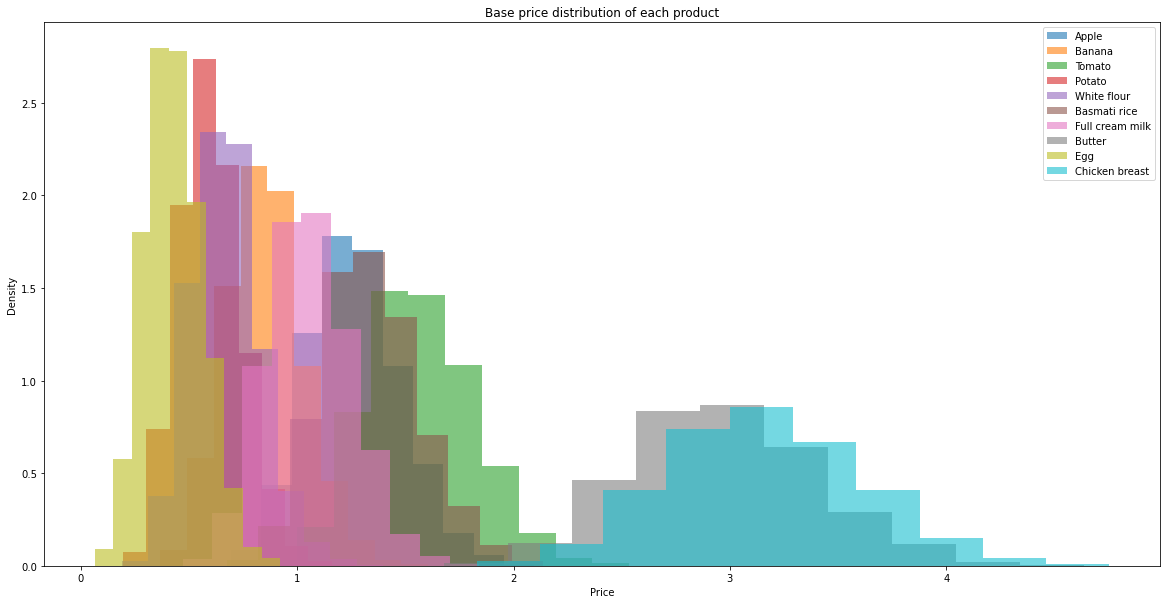

In [20]:
# Plotting
samples = result.extract()
#Creating a backward dictionary for product to tag the labels in the graphs
product_dict_backwards={}
for i in range(len(product_names)):
    product_dict_backwards[i+1] =  product_names[i] 
plt.figure(figsize=(20,10))
for i in range(len(product_dict)):
    plt.hist(samples['base_price'][:, i], label = product_dict_backwards[i+1], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Price")
plt.ylabel("Density")
plt.title("Base price distribution of each product")
plt.show()

### Analysis: The store multiplier

In [21]:
print(result.stansummary(pars=['store_multiplier']))

Inference for Stan model: anon_model_d88715b64a7bc5d2f508cc379257900e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
store_multiplier[1]    4.07    0.04   0.98   2.33   3.38    4.0   4.68   6.14    767    1.0
store_multiplier[2]    5.91    0.05   1.17   3.86   5.07   5.84   6.65   8.45    610   1.01
store_multiplier[3]    4.09    0.03   0.99   2.35    3.4   4.02   4.71   6.22    832   1.01
store_multiplier[4]    7.05    0.06   1.41   4.65   6.04   6.96   7.95  10.09    621   1.01
store_multiplier[5]     4.2    0.04   0.97   2.53   3.51   4.12    4.8   6.34    705    1.0
store_multiplier[6]    4.13    0.03    1.0   2.42   3.42   4.03   4.75   6.31    840    1.0
store_multiplier[7]     3.6    0.03   0.95   1.94   2.96   3.51   4.16   5.69    946    1.0
store_multiplier[8]    4.55    0.04   1.08   2.68   3.78   4.49   5.23    6

In [22]:
#To figure out the index of each store to match it with the results above, consult the store dictionary
store_dict

{'EDEKA, Grunerstraße 20': 1,
 'EDEKA Andreasstraße 59, 10243 Berlin': 2,
 'EDEKA BAUR, Gottlieber Str. 34, 78462 Konstanz': 3,
 'Alnatura Super Natur Markt, Münzgasse 4A, 78462 Konstanz': 4,
 'EDEKA, Annenstraße 4A': 5,
 "Sainsbury's, 31-41 Liverpool Rd, The Angel, London N1 0RW  https://goo.gl/maps/9zA18NrH7bHc7pUY7": 6,
 'Tesco Express, 122-128 Pentonville Rd, Islington, London N1 9TT  https://goo.gl/maps/Zt7ELbyjDjfVa89k8': 7,
 'REWE, Litfaß-Platz 4': 8,
 'Tesco Express, 55 Central St, Clerkenwell, London EC1V 3AF': 9,
 'Tesco Express, 10 Smithfield St, Farringdon, London EC1A 9LR': 10,
 "Tesco Express, 14-16 St Martin's Le Grand, London EC2V 6BJ": 11,
 'Foodsco - 1800 Folsom Street, San Francisco ': 12,
 "Trader Joe's, 10 4th St, San Francisco, CA 94103": 13,
 'Safeway, 298 King St, San Francisco, CA 94107': 14,
 'ALDI, Eisenbahnstraße 42': 15,
 'EDEKA, Hasenheide 57': 16,
 '17050 Van Buren Boulevard, Riverside, CA 92504': 17,
 '315 E Alessandro Blvd, Riverside, CA 92508': 18,
 'T

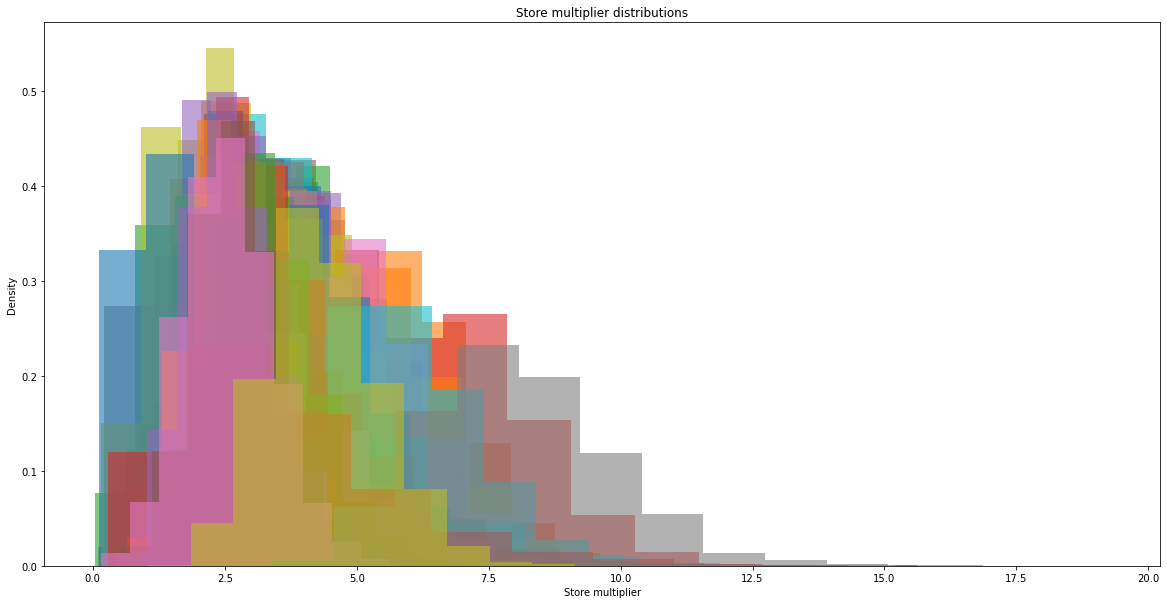

In [23]:
#Creating a backward dictionary for store names to tag the labels in the graphs
store_dict_backwards={}
for i in range(len(store_names)):
    store_dict_backwards[i+1] = store_names[i]
plt.figure(figsize=(20,10))
for i in range(len(store_dict)):
    plt.hist(samples['store_multiplier'][:, i], label = store_dict_backwards[i+1], density = True, alpha=0.6)
plt.xlabel("Store multiplier")
plt.ylabel("Density")
plt.title("Store multiplier distributions")
plt.show()

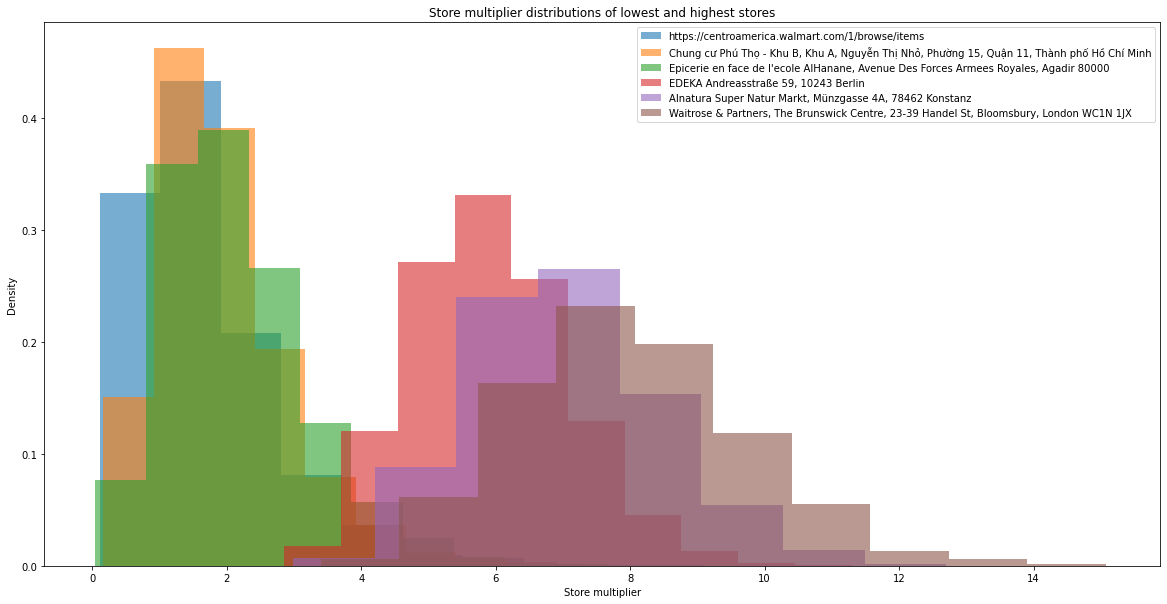

In [24]:
#Consider only the 3 stores with the lowest mean multiplier and 3 stores with the highest mean multiplier
lst_mean_store_multiplier = []
for i in range(len(store_dict)):
    lst_mean_store_multiplier.append(np.mean(samples['store_multiplier'][:, i]))
lst_mean_store_multiplier_sorted = sorted(lst_mean_store_multiplier)
lowest_3=[]
highest_3=[]
lowest_3 = lst_mean_store_multiplier_sorted[:3]
highest_3 = lst_mean_store_multiplier_sorted[len(lst_mean_store_multiplier_sorted)-3:]
index_low = []
index_high=[]
for i in lowest_3:
    index_low.append(lst_mean_store_multiplier.index(i))
for i in highest_3:
    index_high.append(lst_mean_store_multiplier.index(i))
plt.figure(figsize=(20,10))
for i in index_low:
    plt.hist(samples['store_multiplier'][:, i], label = store_dict_backwards[i+1], density = True, alpha=0.6)
for i in index_high:
    plt.hist(samples['store_multiplier'][:, i], label = store_dict_backwards[i+1], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Store multiplier")
plt.ylabel("Density")
plt.title("Store multiplier distributions of lowest and highest stores")
plt.show()

### Analysis: The country multiplier

In [25]:
print(result.stansummary(pars=['country_multiplier']))

Inference for Stan model: anon_model_d88715b64a7bc5d2f508cc379257900e.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
country_multiplier[1]   0.79  7.8e-3   0.17    0.5   0.66   0.77   0.89   1.18    490   1.01
country_multiplier[2]   0.93    0.01   0.23   0.57   0.76    0.9   1.06   1.46    504   1.01
country_multiplier[3]   0.91    0.01   0.24   0.55   0.74   0.87   1.04   1.46    436   1.01
country_multiplier[4]   0.86    0.01   0.42   0.35   0.58   0.77   1.04   1.95   1014    1.0
country_multiplier[5]   1.31    0.02   0.71   0.49   0.84   1.14   1.59   3.18   1055    1.0
country_multiplier[6]   2.58    0.04   1.76   0.59   1.32    2.1   3.31   7.24   1870    1.0
country_multiplier[7]   1.35    0.03    0.9   0.38   0.75   1.11   1.67   3.76   1273    1.0

Samples were drawn using NUTS at Thu Nov  5 18:43:20 2020.
For eac

In [26]:
#To figure out the index of each country to match it with the results above, consult the country dictionary
country_dict

{'Germany': 1,
 'UK': 2,
 'United States': 3,
 'Morocco': 4,
 'Vietnam': 5,
 'South Korea': 6,
 'Guatemala': 7}

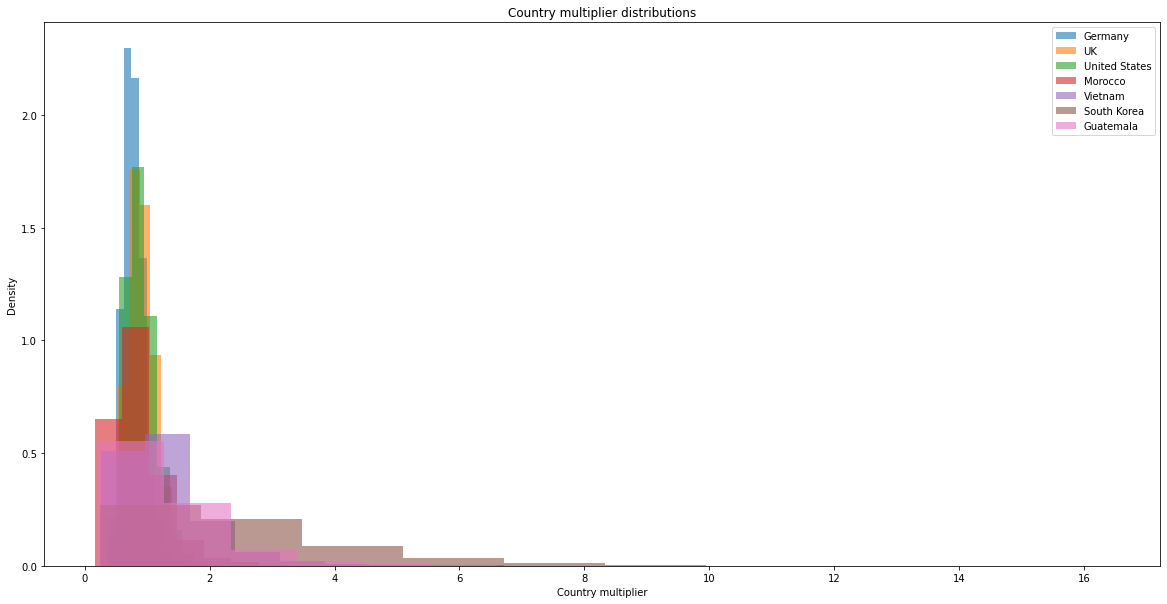

In [27]:
#Creating a backward dictionary for country names to tag the labels in the graphs
country_dict_backwards={}
for i in range(len(country_names)):
    country_dict_backwards[i+1] = country_names[i]
plt.figure(figsize=(20,10))
for i in range(len(country_dict)):
    plt.hist(samples['country_multiplier'][:, i], label = country_dict_backwards[i+1], density = True, alpha=0.6)
plt.legend()
plt.xlabel("Country multiplier")
plt.ylabel("Density")
plt.title("Country multiplier distributions")
plt.show()

### Analysis: Correlation between price variation by geographical location and rental price variation

In [28]:
#Create a dictionary with name of store with corresponding rental price
store_rent_dict={}
for i in range(len(store_names)):
    if np.isnan(dta['Rent per m2'].loc[i]) == False:
        store_rent_dict[store_names[i]] = dta['Rent per m2'].loc[i] 

In [29]:
#Get the list of store multipliers from above
mean_store_multiplier = []
for i in range(0, len(store_rent_dict)): 
    mean_store_multiplier.append(np.mean(samples['store_multiplier'][:, i]))
    

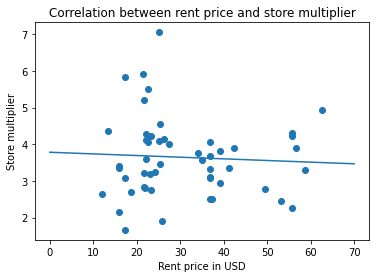

In [30]:
plt.figure()
rent_prices = list(store_rent_dict.values())
multiplier = mean_store_multiplier
plt.scatter(rent_prices, multiplier)
#Creating the line of best fit
result_regression = sts.linregress(rent_prices, multiplier)
slope = result_regression[0]
intercept = result_regression[1]
x = np.linspace(0, 70, 500)
plt.plot(x, intercept + slope*x)
plt.title('Correlation between rent price and store multiplier')
plt.xlabel('Rent price in USD')
plt.ylabel('Store multiplier')
plt.show()

In [31]:
print("The correlation coefficient is", result_regression[2])
print("The p value is", result_regression[3])

The correlation coefficient is -0.05746592406376195
The p value is 0.6857319440518803
